In [1]:
# 必要なパッケージを呼び出す
using NLsolve
using Plots
using Roots

In [2]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする
struct Model{TI<:Integer, TF<:AbstractFloat}

    # カリブレーション
    alpha::TF 
    beta::TF           
    delta::TF 
    Abar::TF

    # 定常状態の値
    kss::TF
    css::TF    
    
    # 移行過程に関する変数
    T::TI

end

In [14]:
function shooting(m,x,k0)
    """
    ------------------------------------------------------
    === ためし打ち法において、消費と資本の流列を求める関数 ===
    ------------------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・x: 消費の初期値(求根問題のためにベクトル表記する)
    ・k0: 資本の初期値
    <output>
    ・k: 資本の流列
    ・c: 消費の流列
    """
    
    c0 = x[1];
    k = zeros(m.T+1);
    c = zeros(m.T+1);

    k[1] = k0;
    c[1] = c0;

    for t in 1:T

        k[t+1] = max(m.Abar*(k[t]^m.alpha) + (1-m.delta)*k[t] - c[t], 1e-4); # k>0
        c[t+1] = m.beta*c[t]*(1 + m.Abar*m.alpha*(k[t+1]^(m.alpha-1)) - m.delta);

    end

    return k, c
end

shooting (generic function with 1 method)

In [4]:
function shooting_err(m,x,k0)
    """
    --------------------------------------------------------------
    === ためし打ち法において、資本の定常状態とk_{T}の差を求める関数 ===
    --------------------------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・x: 消費の初期値(求根問題のためにベクトル表記する)
    ・k0: 資本の初期値
    <output>
    ・err: 資本の定常状態とk_{T}の差
    """

    k, c = shooting(m,x,k0);
    err = k[m.T+1] - m.kss;

    return err
end

shooting_err (generic function with 1 method)

In [5]:
# カリブレーション
alpha = 0.4; 
beta = 0.96;
delta = 1.0; 
Abar = 1.0;

# 定常状態の値
kss = (alpha*beta*Abar/(1-beta*(1-delta)))^(1/(1-alpha));
css = kss^alpha - delta*kss;

# 移行過程に関する変数
T = 30; 

# k の初期値
k0 = 0.1; 

####  1. using find_zero 

In [6]:
m = Model(alpha,beta,delta,Abar,kss,css,T);

c0 = find_zero(x->shooting_err(m,x,k0),(0.0,10.0));
k,c = shooting(m,[c0],k0);

In [25]:
c0

0.24523401706095432

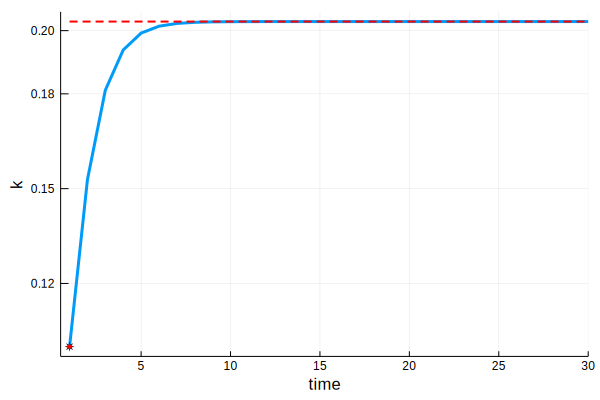

In [7]:
plot(k[1:T],legend=false,lw=3)
scatter!([1.0],[k[1]],c=:red,markershape=:star8)
plot!([1,100],[m.kss,m.kss],c=:red,ls=:dash,lw=2)
xlabel!("time")
ylabel!("k")
xlims!(0.5,m.T)

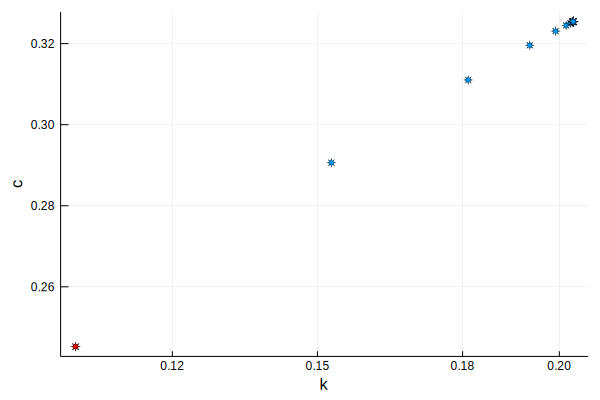

In [8]:
scatter(k,c,markershape=:star8,legend=false)
scatter!([k[1]],[c[1]],markershape=:star8,c=:red)
xlabel!("k")
ylabel!("c")

#### 2.bisection

In [27]:
# 2. bisection
cL = 0.20;
cH = 0.30;
it = 1;
maxit = 1000;
dif = 1e+4;

while (dif > 1e-15) && (it < maxit)

    c0 = (cL+cH)/2;
    k,c = shooting(m,[c0],k0);
    err = k[T+1] - m.kss;
    if err > 0
        cL = copy(c0);
    else
        cH = copy(c0);
    end

    #println([it,err])
    #flush(stdout)
    it += 1
end 

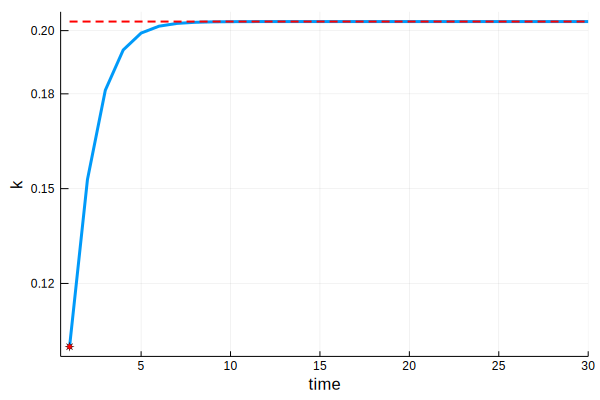

In [10]:
plot(k[1:T],legend=false,lw=3)
scatter!([1.0],[k[1]],c=:red,markershape=:star8)
plot!([1,100],[kss,kss],c=:red,ls=:dash,lw=2)
xlabel!("time")
ylabel!("k")
xlims!(0.5,m.T)

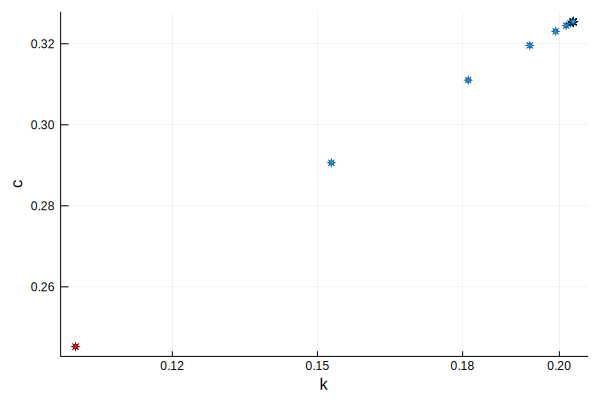

In [11]:
scatter(k,c,markershape=:star8,legend=false)
scatter!([k[1]],[c[1]],markershape=:star8,c=:red)
xlabel!("k")
ylabel!("c")